In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [5]:
# Try diffusing when propertylandusetypeid is 261.0 and when it is not.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

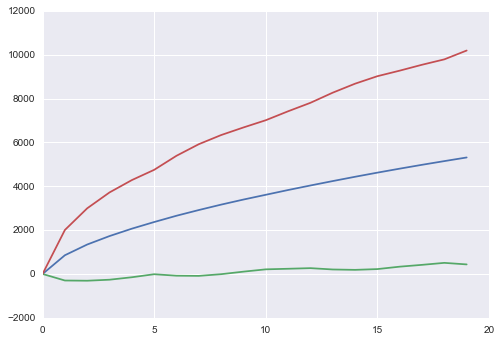

In [6]:
# Get an idea of how large the distances are for up to 20 neighbors
nbrs = NearestNeighbors(20)
nbrs.fit(vals_df[['latitude', 'longitude']])
points = vals_df[['latitude', 'longitude']]
distances, indices = nbrs.kneighbors(points)
meandist = np.mean(distances, axis = 0)
stddist = np.std(distances, axis = 0)

plt.plot(meandist)
plt.plot(meandist - stddist)
plt.plot(meandist + stddist)
plt.show()

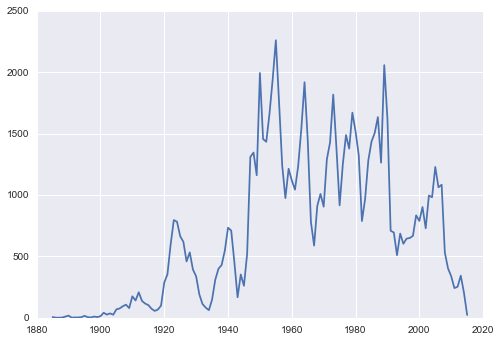

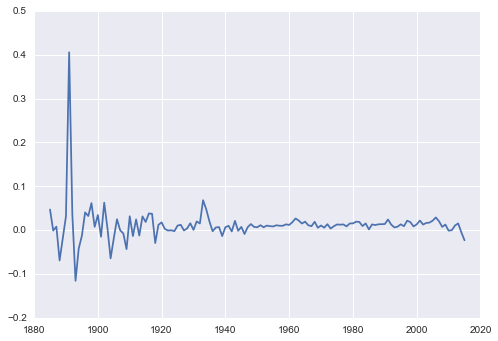

In [7]:
# Let's investigate diffusing the year built.

vars_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]

grouped_df = vars_df.groupby('yearbuilt').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vars_df.groupby('yearbuilt').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

In [19]:
# Find initial diffusion data, use average depending on distance.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()
diffinit = vals_df['yearbuilt'].values.T
        
errors = []

ks = range(1, 80, 4)
nbrs = NearestNeighbors()
nbrs.fit(vals_df[['latitude', 'longitude']])

diffusions = np.zeros(diffinit.shape)
coords = vals_df[['latitude', 'longitude']].values

epsilon = 10**3
for k in ks:
    
    nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

    nbrdiffusions = diffinit[nbrindex]
    nbrdistance += epsilon
    nbrdistance = 1.0 / nbrdistance
    meandiffusions = nbrdistance * nbrdiffusions
    meandiffusions = np.sum(meandiffusions, axis = 1)
    meandiffusions /= np.sum(nbrdistance, axis = 1)
    newdiffusions = np.stack((meandiffusions, diffinit))
    diffusions = np.amax(newdiffusions, axis = 0)
    
    linregr = linear_model.LinearRegression()
    x_train = np.stack((diffusions, usetypes.T)).T
    #x_train = x_train.reshape(-1,1)
    y_train = vals_df['logerror'].values
    y_train = y_train.reshape(-1,1)
    
    linregr.fit(x_train, y_train)
    y_predict = linregr.predict(x_train)
    newerrors = y_train - y_predict
    errors.append(newerrors)

(20, 89519, 1)


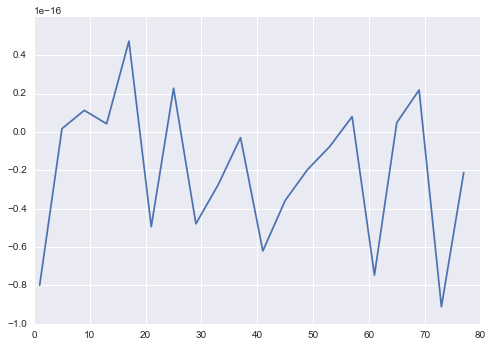

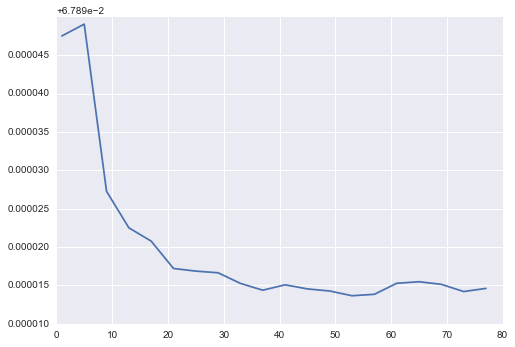

In [18]:
errors = np.array(errors)
print(errors.shape)
abserrors = np.abs(errors)

plt.plot(ks, np.mean(errors, axis = 1))
plt.show()

plt.plot(ks, np.mean(abserrors, axis = 1))
plt.show()

In [54]:
# Try using 35 neighbors.

k = 35
nbrdistance, nbrindex = nbrs.kneighbors(coords, n_neighbors = k)

nbrdiffusions = diffinit[nbrindex]
nbrdistance += epsilon
nbrdistance = 1.0 / nbrdistance
meandiffusions = nbrdistance * nbrdiffusions
meandiffusions = np.sum(meandiffusions, axis = 1)
meandiffusions /= np.sum(nbrdistance, axis = 1)
newdiffusions = np.stack((meandiffusions, diffinit))
diffusions = np.amax(newdiffusions, axis = 0)

In [55]:
# Bin diffusion values.

nbins = 200
minval = np.amin(diffusions)
maxval = np.amax(diffusions)
bindiffusions = (diffusions - minval) / (maxval - minval) * nbins
bindiffusions = bindiffusions.astype(int)
bindiffusions = bindiffusions * (maxval - minval) / nbins + minval

vals_df['bindiffusions'] = bindiffusions

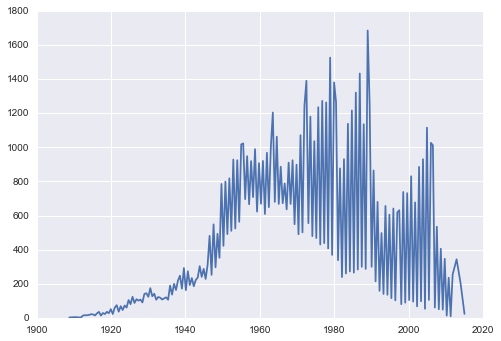

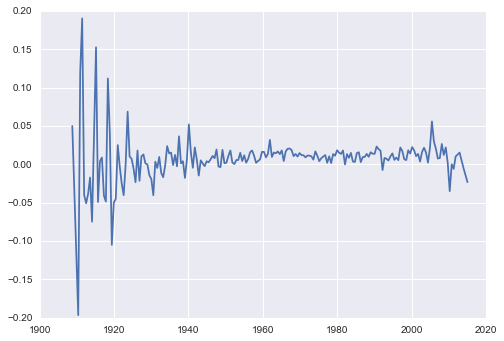

In [56]:
# Group the data by bins for diffusion values.

grouped_df = vals_df.groupby('bindiffusions').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('bindiffusions').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

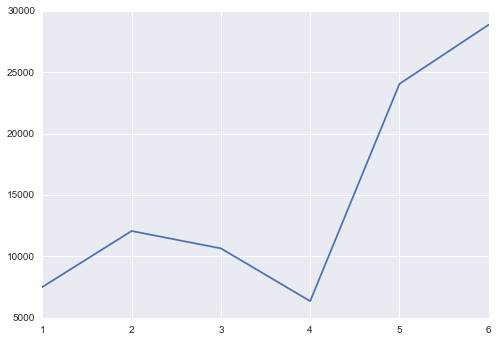

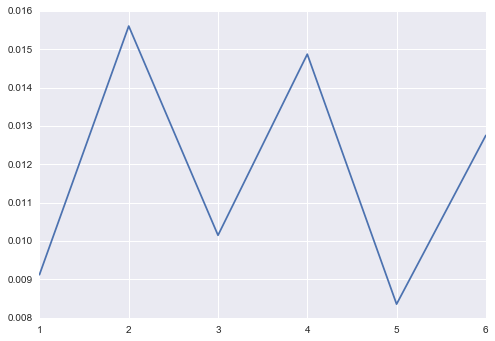

In [63]:
# Investigate these peaks that have formed in the year built distribution.

diffusion_cat = diffusions.copy()
for i in range(len(diffusion_cat)):
    val = diffusion_cat[i]
    if 1955 < val and val < 1960:
        diffusion_cat[i] = 1
    elif 1960 < val and val < 1968:
        diffusion_cat[i] = 2
    elif 1970 < val and val < 1977:
        diffusion_cat[i] = 3
    elif 1987 < val and val < 1992:
        diffusion_cat[i] = 4
    elif 1930 < val and val < 1980:
        diffusion_cat[i] = 5
    else:
        diffusion_cat[i] = 6
        
vals_df['diffusion_cat'] = diffusion_cat.T

grouped_df = vals_df.groupby('diffusion_cat').count()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

grouped_df = vals_df.groupby('diffusion_cat').mean()
plt.plot(grouped_df.index, grouped_df['logerror'])
plt.show()

In [64]:
# Now try just simply using the mean values of diffusion category.
grouped_df = vals_df.groupby('diffusion_cat').mean()
catpredict = grouped_df['logerror'].values

newpredict = []
for i in range(len(diffusion_cat)):
    newpredict = catpredict[int(diffusion_cat[i] - 1)]
    
errorpredict = newpredict - vals_df['logerror'].values

print('mean error prediction = ', np.mean(errorpredict))
newesterror = np.mean(np.abs(errorpredict))
print('abs error prediction = ', newesterror)
origerror = np.mean(np.abs(vals_df['logerror'].values))
print('Original abs error = ', origerror)
print('Difference = ', newesterror - origerror)

(newesterror - origerror) / origerror

mean error prediction =  -0.00313681533286
abs error prediction =  0.0676513740121
Original abs error =  0.0678984975257
Difference =  -0.000247123513588


-0.0036396020912662025